# Exploratory Data Analysis (EDA)

**Notebook:** `exploratory_analysis.ipynb`

**Purpose:**
- Perform thorough exploratory analysis of the SLTDA tourism dataset (2010–2024).
- Identify missing values, structural zeros (pandemic months), seasonality, trends, outliers, and key summary statistics.
- Create derived metrics useful for modeling (e.g., revenue per tourist).

---

Run cells sequentially. This notebook uses `pandas`, `numpy`, `matplotlib`, `statsmodels`, and `scipy`.

In [1]:
# Imports and display settings
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

pd.options.display.float_format = '{:,.3f}'.format

DATA_PATHS = [Path('../data/tourism_clean.csv'), Path('../data/tourism.csv'), Path('/mnt/data/tourism-repo-template/data/tourism.csv')]
data_path = None
for p in DATA_PATHS:
    if p.exists():
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError('Could not find tourism CSV in expected locations. Place tourism.csv or tourism_clean.csv in ../data/')

print('Loading data from:', data_path)

Loading data from: ..\data\tourism_clean.csv


In [3]:
# Load dataset
df = pd.read_csv(data_path)
# Normalize column names
df.columns = [c.strip() for c in df.columns]
# Create datetime 'date' column
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df['year'].astype(int).astype(str) + '-' + df['month'].astype(int).astype(str).str.zfill(2) + '-01')

df = df.sort_values('date').reset_index(drop=True)
print('Rows loaded:', len(df))
df.head()

Rows loaded: 180


,year,month,tourist_arrivals,tourism_revenue_usd,avg_stay,avg_daily_spend,hotel_occupancy_rate,exchange_rate_lkr_usd,tourism_employment,date,is_pandemic_zero,period
0,2010,1,"50,757.000","44,916,899.580",9.800,90.300,73.600,114.300,4267,2010-01-01,False,pre_2020
1,2010,2,"57,300.000","51,140,250.000",10.200,87.500,72.900,114.100,4817,2010-02-01,False,pre_2020
2,2010,3,"52,352.000","46,900,586.240",10.100,88.700,72.200,113.800,4401,2010-03-01,False,pre_2020
3,2010,4,"38,300.000","34,281,181.000",10.300,86.900,66.600,113.500,3220,2010-04-01,False,pre_2020
4,2010,5,"35,213.000","30,433,539.510",9.700,89.100,59.600,113.200,2960,2010-05-01,False,pre_2020


In [4]:
# Data types and missing values
print('Data types:')
print(df.dtypes)
print('\nMissing values per column:')
print(df.isnull().sum())

Data types:
year                       int64
month                      int64
tourist_arrivals         float64
tourism_revenue_usd      float64
avg_stay                 float64
avg_daily_spend          float64
hotel_occupancy_rate     float64
exchange_rate_lkr_usd    float64
tourism_employment         int64
date                      object
is_pandemic_zero            bool
period                    object
dtype: object

Missing values per column:
year                     0
month                    0
tourist_arrivals         0
tourism_revenue_usd      0
avg_stay                 0
avg_daily_spend          0
hotel_occupancy_rate     0
exchange_rate_lkr_usd    0
tourism_employment       0
date                     0
is_pandemic_zero         0
period                   0
dtype: int64


In [5]:
# Ensure numeric columns are numeric (coerce errors)
num_cols = ['tourist_arrivals','tourism_revenue_usd','avg_stay','avg_daily_spend','hotel_occupancy_rate','exchange_rate_lkr_usd','tourism_employment']
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
print('Converted numeric columns. Sample:') 
df[num_cols].head()

Converted numeric columns. Sample:


,tourist_arrivals,tourism_revenue_usd,avg_stay,avg_daily_spend,hotel_occupancy_rate,exchange_rate_lkr_usd,tourism_employment
0,"50,757.000","44,916,899.580",9.800,90.300,73.600,114.300,4267
1,"57,300.000","51,140,250.000",10.200,87.500,72.900,114.100,4817
2,"52,352.000","46,900,586.240",10.100,88.700,72.200,113.800,4401
3,"38,300.000","34,281,181.000",10.300,86.900,66.600,113.500,3220
4,"35,213.000","30,433,539.510",9.700,89.100,59.600,113.200,2960


## Basic summary statistics
Compute summary statistics for the main numeric columns.

In [6]:
display(df[num_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
tourist_arrivals,180.000,"113,852.617","66,851.406",0.000,"64,892.500","112,033.000","156,447.250","253,169.000"
tourism_revenue_usd,180.000,"167,483,705.916","108,975,888.326",0.000,"71,822,358.735","165,355,747.605","250,506,801.657","393,295,682.350"
avg_stay,180.000,9.625,2.696,0.000,8.775,10.100,10.400,15.100
avg_daily_spend,180.000,104.619,53.810,0.000,54.017,104.600,156.275,201.650
hotel_occupancy_rate,180.000,58.577,22.323,1.800,51.150,66.750,74.800,86.400
exchange_rate_lkr_usd,180.000,181.707,75.933,109.300,128.775,152.350,195.925,370.900
tourism_employment,180.000,"9,224.383","5,494.949",0.000,"4,812.500","9,462.500","12,579.500","22,862.000"


## Detect zeros & pandemic months
We expect structural zeros in 2020 due to COVID-19. We'll flag months where arrivals == 0.

In [7]:
# Flag zero-arrival months and pandemic period markers
df['is_zero_arrivals'] = (df['tourist_arrivals'] == 0)
df['year'] = df['year'].astype(int)
df['period'] = pd.cut(df['year'], bins=[2009,2019,2020,2024], labels=['pre_2020','pandemic_2020','post_2020'], right=True)
df['period'] = df['period'].cat.add_categories(['unknown']).fillna('unknown')

# Counts
print('Zero-arrival months total:', df['is_zero_arrivals'].sum())
print('\nCounts by period:')
print(df['period'].value_counts())

Zero-arrival months total: 9

Counts by period:
period
pre_2020         120
post_2020         48
pandemic_2020     12
unknown            0
Name: count, dtype: int64


## Derived metrics
Create `revenue_per_tourist` and `revenue_per_tourist_est` (where possible).

In [8]:
# revenue per tourist (handle division by zero)
df['revenue_per_tourist'] = np.where(df['tourist_arrivals']>0, df['tourism_revenue_usd'] / df['tourist_arrivals'], np.nan)
# revenue per tourist estimated from avg_daily_spend * avg_stay (if both present)
df['revenue_per_tourist_est'] = df['avg_daily_spend'] * df['avg_stay']
display(df[['date','tourist_arrivals','tourism_revenue_usd','revenue_per_tourist','revenue_per_tourist_est']].head(12))

,date,tourist_arrivals,tourism_revenue_usd,revenue_per_tourist,revenue_per_tourist_est
0,2010-01-01,"50,757.000","44,916,899.580",884.940,884.940
1,2010-02-01,"57,300.000","51,140,250.000",892.500,892.500
2,2010-03-01,"52,352.000","46,900,586.240",895.870,895.870
3,2010-04-01,"38,300.000","34,281,181.000",895.070,895.070
4,2010-05-01,"35,213.000","30,433,539.510",864.270,864.270
5,2010-06-01,"44,730.000","39,183,480.000",876.000,876.000
6,2010-07-01,"63,339.000","57,434,538.420",906.780,906.780
7,2010-08-01,"55,898.000","49,473,083.880",885.060,885.060
8,2010-09-01,"47,339.000","41,644,591.690",879.710,879.710
9,2010-10-01,"52,370.000","45,266,533.200",864.360,864.360


## Missingness overview
Count missing values per column and show months with any missing numeric data.

In [9]:
missing_counts = df[num_cols].isnull().sum().sort_values(ascending=False)
print(missing_counts)

# Rows with any missing numeric
rows_with_missing = df[df[num_cols].isnull().any(axis=1)]
print('\nRows with any numeric missing:', len(rows_with_missing))
rows_with_missing[['date'] + [c for c in num_cols if c in df.columns]].head(10)

tourist_arrivals         0
tourism_revenue_usd      0
avg_stay                 0
avg_daily_spend          0
hotel_occupancy_rate     0
exchange_rate_lkr_usd    0
tourism_employment       0
dtype: int64

Rows with any numeric missing: 0


,date,tourist_arrivals,tourism_revenue_usd,avg_stay,avg_daily_spend,hotel_occupancy_rate,exchange_rate_lkr_usd,tourism_employment


## Time-series: Tourist Arrivals
Plot monthly tourist arrivals across the full period.

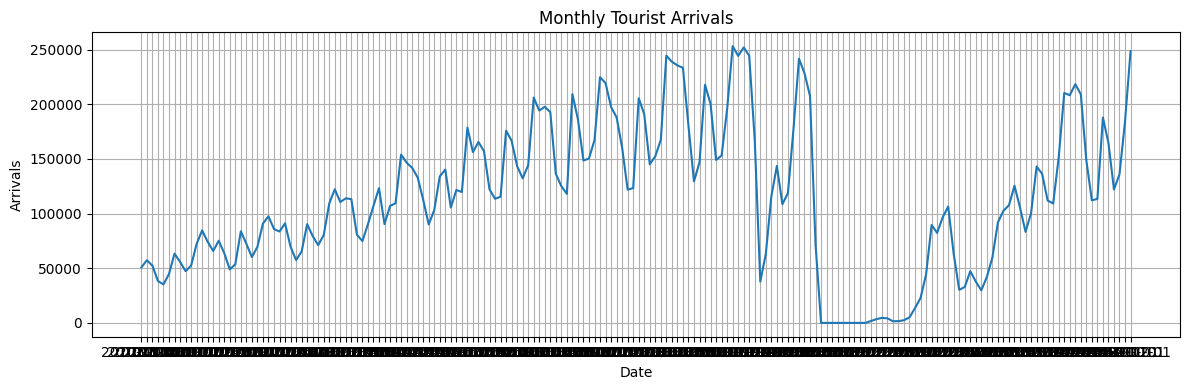

In [10]:
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['tourist_arrivals'])
plt.title('Monthly Tourist Arrivals')
plt.xlabel('Date')
plt.ylabel('Arrivals')
plt.grid(True)
plt.tight_layout()
plt.show()

## Time-series: Tourism Revenue (USD)
Plot monthly tourism revenue across the full period.

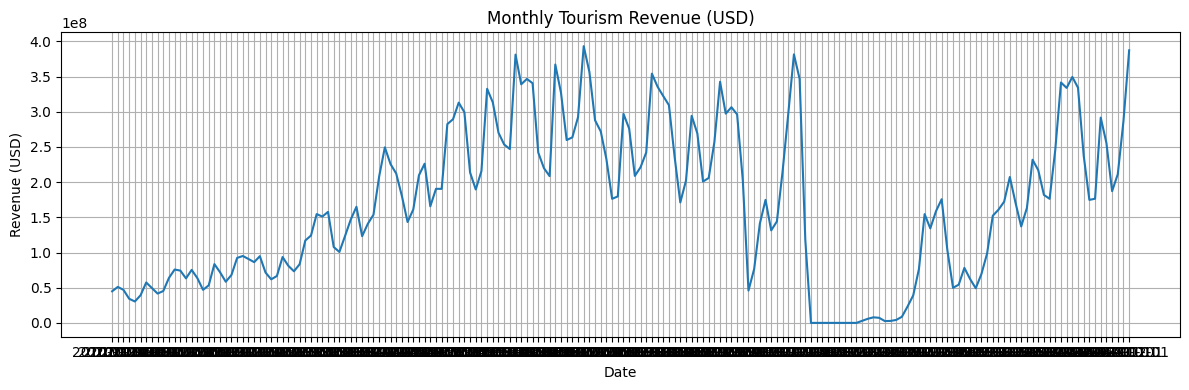

In [11]:
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['tourism_revenue_usd'])
plt.title('Monthly Tourism Revenue (USD)')
plt.xlabel('Date')
plt.ylabel('Revenue (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Time-series: Average Daily Spend

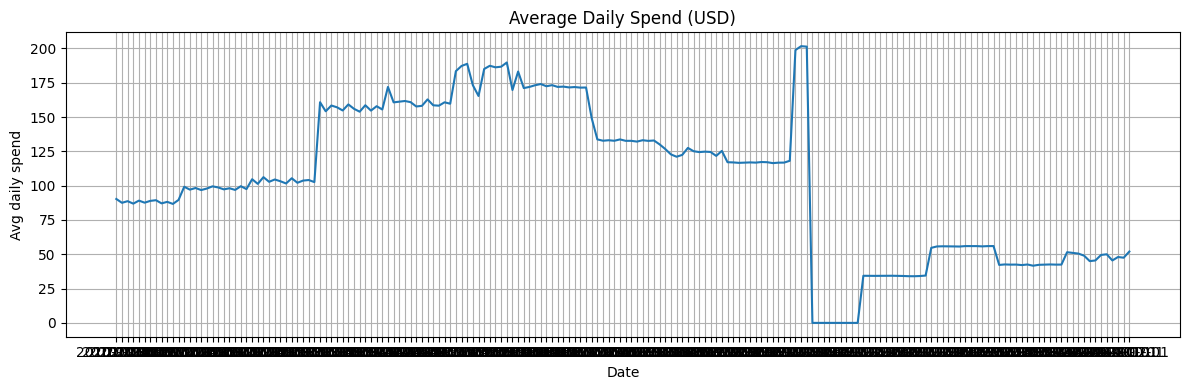

In [12]:
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['avg_daily_spend'])
plt.title('Average Daily Spend (USD)')
plt.xlabel('Date')
plt.ylabel('Avg daily spend')
plt.grid(True)
plt.tight_layout()
plt.show()

## Monthly seasonality (average across years)
Compute month-of-year averages to inspect seasonal patterns.

    month  tourist_arrivals  tourism_revenue_usd  avg_daily_spend
0       1       142,949.070      216,404,490.780          117.290
1       2       142,951.130      212,483,062.300          114.840
2       3       133,176.330      196,577,469.870          115.410
3       4        96,856.270      140,286,704.990          100.340
4       5        70,761.270      103,383,963.230           99.610
5       6        78,143.270      114,908,099.050          101.430
6       7       118,879.200      175,306,420.230          101.270
7       8       113,532.730      166,573,875.510          101.600
8       9        89,772.130      131,700,930.270          100.930
9      10        96,522.870      140,855,302.960          101.210
10     11       119,509.130      171,973,439.970          100.090
11     12       163,178.000      239,350,711.830          101.400


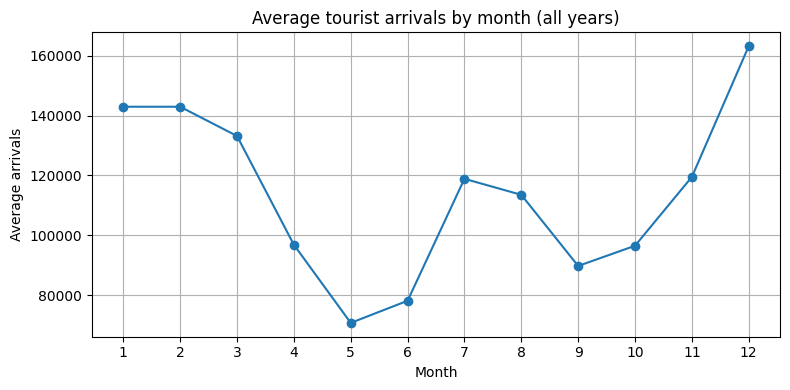

In [26]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.month
monthly_means = df.groupby('month')[['tourist_arrivals','tourism_revenue_usd','avg_daily_spend']].mean().reset_index()
print(monthly_means.round(2))
plt.figure(figsize=(8,4))
plt.plot(monthly_means['month'], monthly_means['tourist_arrivals'], marker='o')
plt.title('Average tourist arrivals by month (all years)')
plt.xlabel('Month')
plt.ylabel('Average arrivals')
plt.xticks(range(1,13))
plt.grid(True)
plt.tight_layout()
plt.show()

## Month-wise boxplot: Tourist Arrivals
Shows distribution of arrivals for each calendar month across years.

C:\Users\nimes\AppData\Local\Temp\ipykernel_19908\2806601352.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=list(range(1,13)))


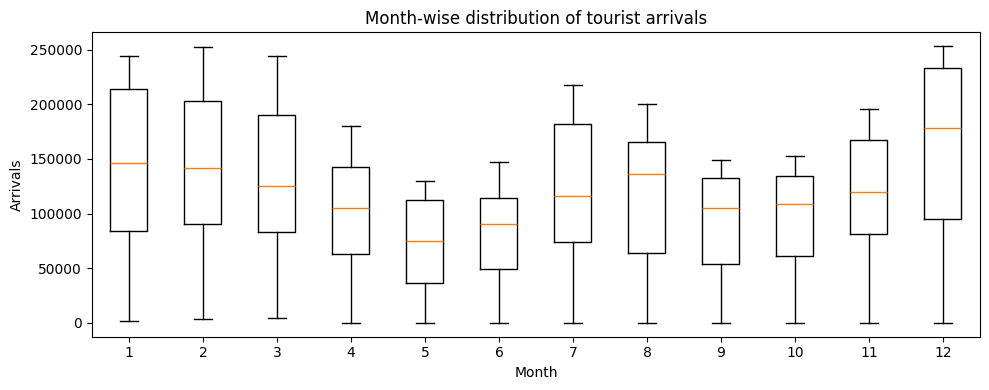

In [14]:
groups = [group['tourist_arrivals'].dropna().values for _, group in df.groupby('month')]
plt.figure(figsize=(10,4))
plt.boxplot(groups, labels=list(range(1,13)))
plt.title('Month-wise distribution of tourist arrivals')
plt.xlabel('Month')
plt.ylabel('Arrivals')
plt.tight_layout()
plt.show()

## Month-wise boxplot: Average Daily Spend

C:\Users\nimes\AppData\Local\Temp\ipykernel_19908\2633401607.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups2, labels=list(range(1,13)))


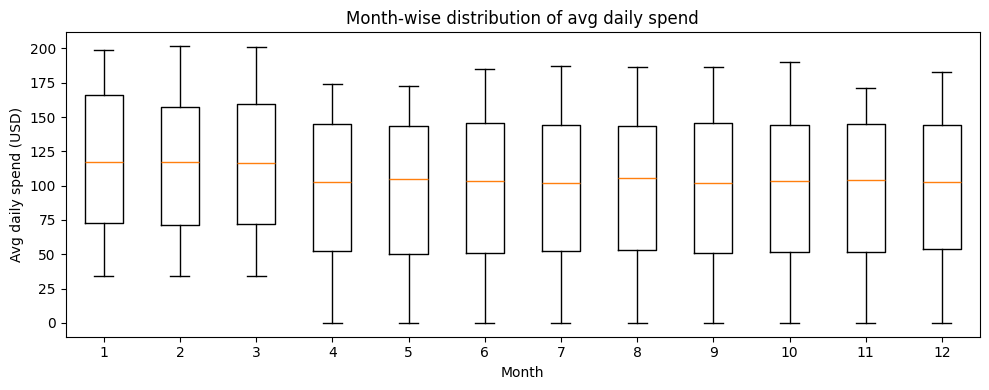

In [15]:
groups2 = [group['avg_daily_spend'].dropna().values for _, group in df.groupby('month')]
plt.figure(figsize=(10,4))
plt.boxplot(groups2, labels=list(range(1,13)))
plt.title('Month-wise distribution of avg daily spend')
plt.xlabel('Month')
plt.ylabel('Avg daily spend (USD)')
plt.tight_layout()
plt.show()

## Correlation matrix (Pearson)
Compute Pearson correlation for numeric columns and plot heatmap.

                       tourist_arrivals  tourism_revenue_usd  avg_stay  \
tourist_arrivals                  1.000                0.962     0.168   
tourism_revenue_usd               0.962                1.000     0.137   
avg_stay                          0.168                0.137     1.000   
avg_daily_spend                   0.532                0.546     0.281   
hotel_occupancy_rate              0.647                0.570     0.265   
exchange_rate_lkr_usd             0.008                0.081    -0.158   
tourism_employment                0.976                0.939     0.129   

                       avg_daily_spend  hotel_occupancy_rate  \
tourist_arrivals                 0.532                 0.647   
tourism_revenue_usd              0.546                 0.570   
avg_stay                         0.281                 0.265   
avg_daily_spend                  1.000                 0.749   
hotel_occupancy_rate             0.749                 1.000   
exchange_rate_lkr_usd  

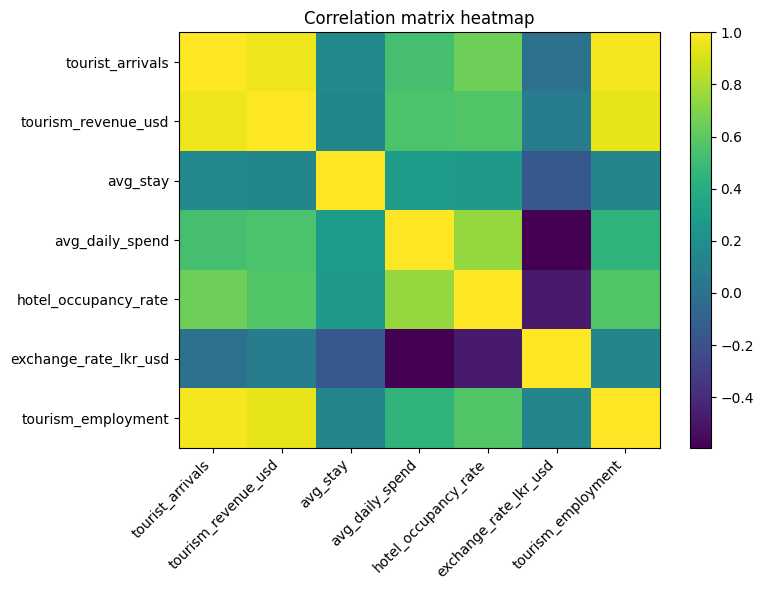

In [16]:
corr_cols = ['tourist_arrivals','tourism_revenue_usd','avg_stay','avg_daily_spend','hotel_occupancy_rate','exchange_rate_lkr_usd','tourism_employment']
corr = df[corr_cols].corr()
print(corr.round(3))

plt.figure(figsize=(8,6))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha='right')
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title('Correlation matrix heatmap')
plt.tight_layout()
plt.show()

## Scatter: Tourist Arrivals vs Tourism Revenue
Check linear relationship visually.

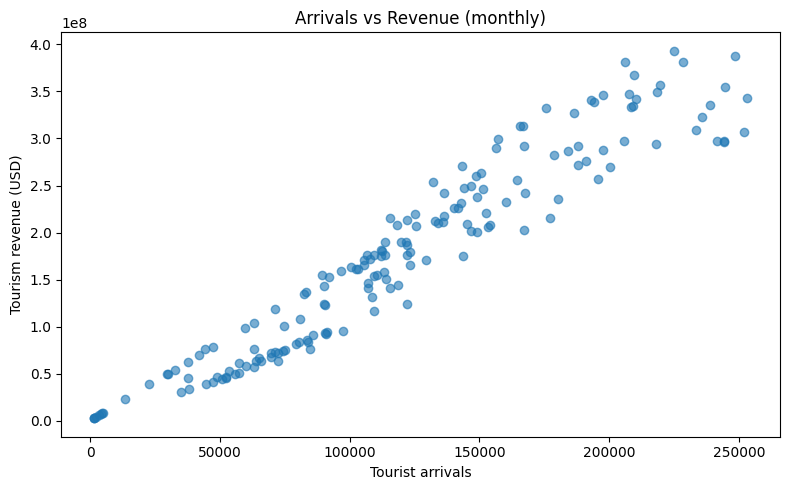

In [17]:
# Remove zeros which distort scatter
tmp = df[(df['tourist_arrivals']>0) & (df['tourism_revenue_usd']>0)].copy()
plt.figure(figsize=(8,5))
plt.scatter(tmp['tourist_arrivals'], tmp['tourism_revenue_usd'], alpha=0.6)
plt.xlabel('Tourist arrivals')
plt.ylabel('Tourism revenue (USD)')
plt.title('Arrivals vs Revenue (monthly)')
plt.tight_layout()
plt.show()

## Rolling 12-month mean: Arrivals & Revenue
Plot rolling averages to smooth short-term noise.

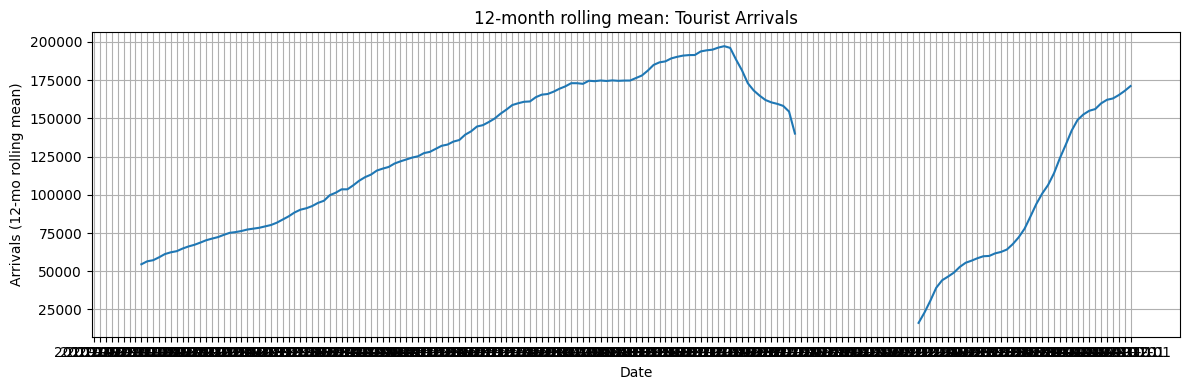

In [18]:
roll_arr = df.set_index('date')['tourist_arrivals'].replace(0, np.nan).rolling(12).mean()
plt.figure(figsize=(12,4))
plt.plot(roll_arr.index, roll_arr)
plt.title('12-month rolling mean: Tourist Arrivals')
plt.xlabel('Date')
plt.ylabel('Arrivals (12-mo rolling mean)')
plt.grid(True)
plt.tight_layout()
plt.show()

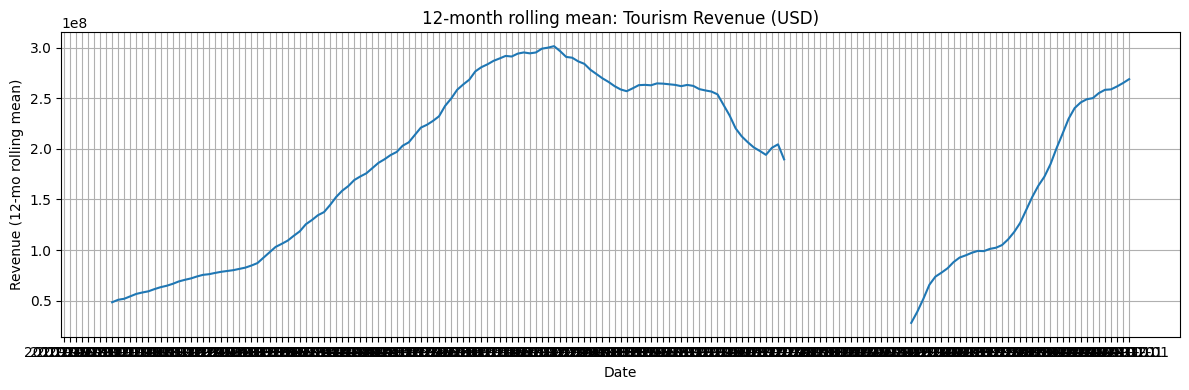

In [19]:
roll_rev = df.set_index('date')['tourism_revenue_usd'].replace(0, np.nan).rolling(12).mean()
plt.figure(figsize=(12,4))
plt.plot(roll_rev.index, roll_rev)
plt.title('12-month rolling mean: Tourism Revenue (USD)')
plt.xlabel('Date')
plt.ylabel('Revenue (12-mo rolling mean)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Seasonal decomposition (additive) of revenue
We decompose the monthly revenue series into trend, seasonal, and residual components. Each component is plotted separately for clarity.

C:\Users\nimes\AppData\Local\Temp\ipykernel_19908\2872343309.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rev_ts = df.set_index('date')['tourism_revenue_usd'].replace(0, np.nan).resample('M').sum()
C:\Users\nimes\AppData\Local\Temp\ipykernel_19908\2872343309.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rev_ts = rev_ts.asfreq('M')
C:\Users\nimes\AppData\Local\Temp\ipykernel_19908\2872343309.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rev_ts_ffill = rev_ts.fillna(method='ffill')


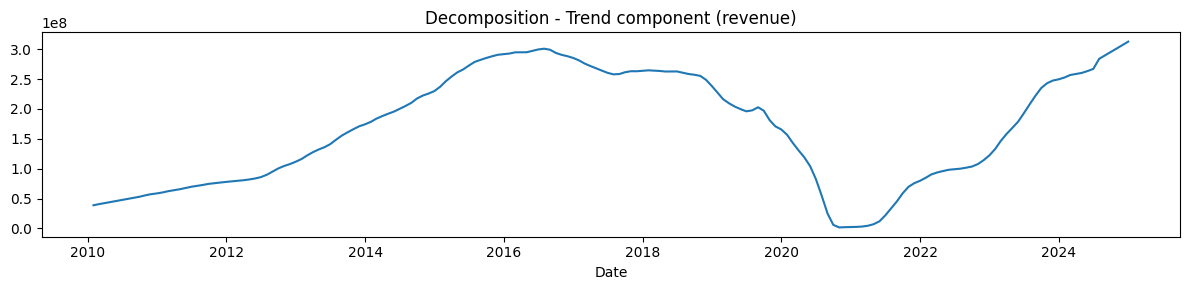

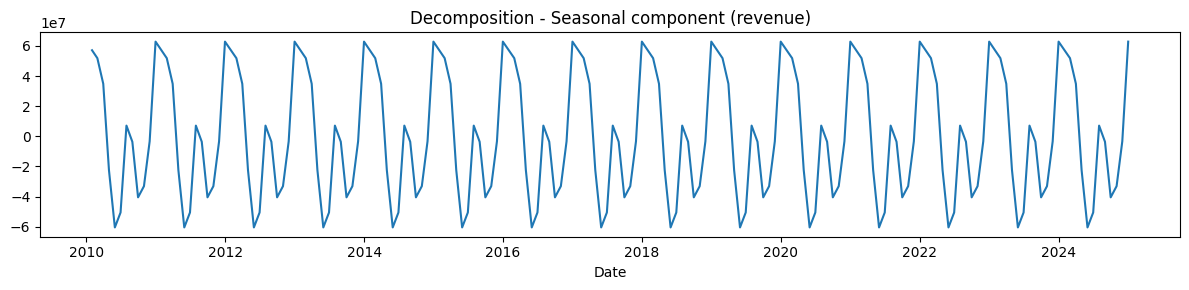

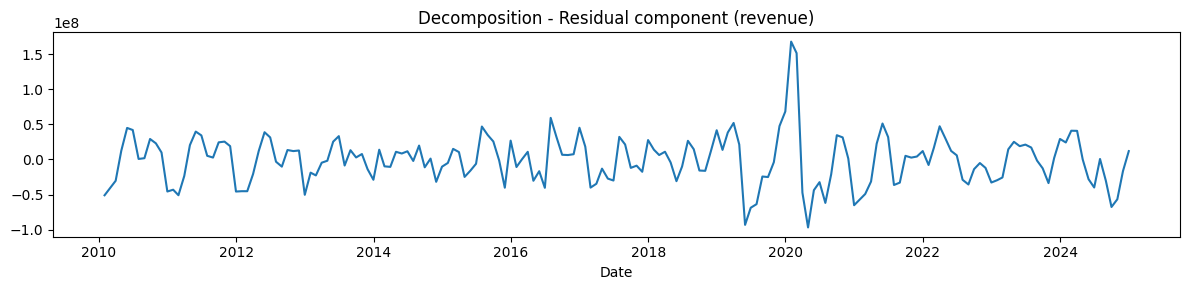

In [25]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
# Prepare monthly revenue series (regular frequency)
rev_ts = df.set_index('date')['tourism_revenue_usd'].replace(0, np.nan).resample('M').sum()
rev_ts = rev_ts.asfreq('M')
# Fill short gaps by forward fill for decomposition (warn: this is simplistic)
rev_ts_ffill = rev_ts.fillna(method='ffill')

res = seasonal_decompose(rev_ts_ffill, model='additive', period=12, extrapolate_trend='freq')

# Plot trend
plt.figure(figsize=(12,3))
plt.plot(res.trend.index, res.trend)
plt.title('Decomposition - Trend component (revenue)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Plot seasonal
plt.figure(figsize=(12,3))
plt.plot(res.seasonal.index, res.seasonal)
plt.title('Decomposition - Seasonal component (revenue)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Plot residuals
plt.figure(figsize=(12,3))
plt.plot(res.resid.index, res.resid)
plt.title('Decomposition - Residual component (revenue)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

## Top & bottom months by arrivals and revenue

In [21]:
# Top 10 months by arrivals
top_arrivals = df.nlargest(10, 'tourist_arrivals')[['date','tourist_arrivals','tourism_revenue_usd']]
print('Top 10 months by tourist arrivals:')
display(top_arrivals)

# Bottom 10 months by arrivals (excluding zeros to show low but non-zero months)
bottom_arrivals = df[df['tourist_arrivals']>0].nsmallest(10,'tourist_arrivals')[['date','tourist_arrivals','tourism_revenue_usd']]
print('\nBottom 10 (non-zero) months by tourist arrivals:')
display(bottom_arrivals)

# Top 10 months by revenue
print('\nTop 10 months by tourism revenue:')
display(df.nlargest(10, 'tourism_revenue_usd')[['date','tourism_revenue_usd','tourist_arrivals']])

Top 10 months by tourist arrivals:


,date,tourist_arrivals,tourism_revenue_usd
107,2018-12-01,"253,169.000","342,707,786.570"
109,2019-02-01,"252,033.000","306,516,485.810"
179,2024-12-01,"248,592.000","387,414,514.940"
95,2017-12-01,"244,536.000","354,263,949.380"
110,2019-03-01,"244,328.000","296,332,726.140"
108,2019-01-01,"244,239.000","297,393,222.050"
119,2019-12-01,"241,663.000","296,895,561.980"
96,2018-01-01,"238,924.000","335,655,726.340"
97,2018-02-01,"235,618.000","322,384,799.740"
98,2018-03-01,"233,382.000","309,444,927.910"



Bottom 10 (non-zero) months by tourist arrivals:


,date,tourist_arrivals,tourism_revenue_usd
136,2021-05-01,"1,497.000","2,587,562.550"
137,2021-06-01,"1,614.000","2,781,083.450"
132,2021-01-01,"1,682.000","2,901,070.340"
138,2021-07-01,"2,429.000","4,185,169.620"
133,2021-02-01,"3,366.000","5,816,735.480"
135,2021-04-01,"4,168.000","7,205,564.960"
134,2021-03-01,"4,581.000","7,910,184.230"
139,2021-08-01,"5,040.000","8,666,308.150"
140,2021-09-01,"13,547.000","23,295,534.620"
141,2021-10-01,"22,771.000","39,199,144.560"



Top 10 months by tourism revenue:


,date,tourism_revenue_usd,tourist_arrivals
83,2016-12-01,"393,295,682.350","224,791.000"
179,2024-12-01,"387,414,514.940","248,592.000"
120,2020-01-01,"381,620,450.280","228,434.000"
71,2015-12-01,"381,293,586.420","206,114.000"
78,2016-07-01,"367,178,625.390","209,351.000"
84,2017-01-01,"356,573,409.120","219,360.000"
95,2017-12-01,"354,263,949.380","244,536.000"
169,2024-02-01,"349,566,198.400","218,350.000"
121,2020-02-01,"346,796,200.710","207,507.000"
73,2016-02-01,"346,738,791.330","197,697.000"


## Outlier detection (Z-score) for tourist arrivals
Flag months where arrivals are extreme (|z| > 3).

In [22]:
arrivals = df['tourist_arrivals'].replace(0, np.nan)
z_scores = np.abs(stats.zscore(arrivals.dropna()))
# align index
z_idx = arrivals.dropna().index
outlier_idx = z_idx[z_scores > 3]
print('Outlier months (|z|>3) for arrivals:')
display(df.loc[df.index.isin(outlier_idx), ['date','tourist_arrivals','tourism_revenue_usd']])

Outlier months (|z|>3) for arrivals:


,date,tourist_arrivals,tourism_revenue_usd


## Save cleaned & derived dataset
We save a copy with derived variables for downstream notebooks.

In [23]:
out_path = Path('../data/tourism_explored.csv')
df.to_csv(out_path, index=False)
print('Saved explored dataset to', out_path)

Saved explored dataset to ..\data\tourism_explored.csv


## Summary of key findings (from EDA)

- The dataset spans 2010–2024 with monthly observations.  
- Structural zeros occur in 2020 (pandemic) and should be treated separately in modeling.  
- Tourist arrivals and revenue show clear seasonality (inspect monthly means above).  
- A strong positive correlation exists between arrivals and revenue (scatterplot & Pearson correlation).  
- Rolling averages and decomposition show recovery patterns after shocks with notable volatility.  

**Next steps:** use `statistical_methods.ipynb` to define samples and hypothesis tests, and `predictions.ipynb` for forecasting using the cleaned series.